# Mapping Features of Slide-seq to Pixel Images
C. Heiser, July 2019

---
The purpose of this notebook is to generate pixellated images from slide-seq outputs.  
* Slide-seq bead array data is irregularly-spaced, as output from SoLiD sequencing of beads _in situ_ 
* Need to interpolate bead presence by nearest-neighbor gridding to create image of tissue that can be colored by metagene features and used for downstream fusion
* Empty beads outside of tissue area need to be ignored as well; we use a KD Tree to map distances of 'real' beads from one another and threshold on this distance to exclude blank slide area from our image

In [1]:
import sys
sys.path.append('../')
from fcc import *

In [10]:
# reload fcc module while working
del sys.modules['fcc']
from fcc import *

In [11]:
# first, read DGE file and bead locations into `pita` object
# here, the bead locations have already been filtered by DGE indices, but if they aren't, you can run pita.filter_beads()
%time puck_180819_5 = pita.from_file(datafile='../inputs/puck_180819_5_mappedDGE.csv.gz', cells_axis=1, beadfile='../inputs/puck_180819_5_beads_trim.csv.gz', data_type='counts')

CPU times: user 2min 14s, sys: 4.23 s, total: 2min 18s
Wall time: 2min 18s


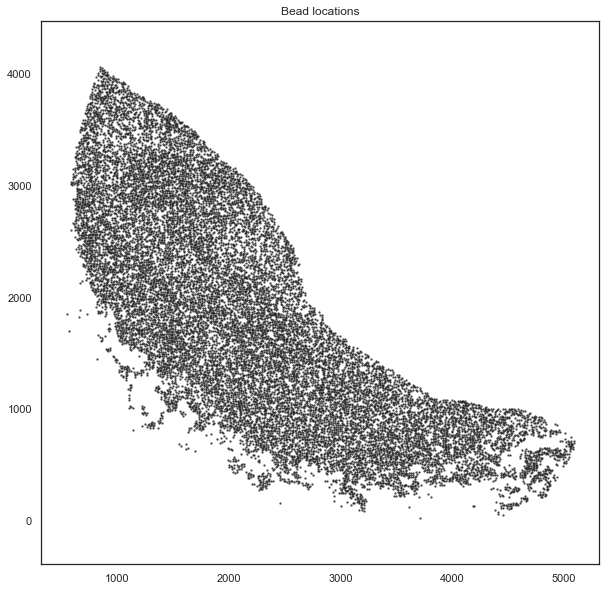

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(puck_180819_5.data['slide-seq']['xcoord'], puck_180819_5.data['slide-seq']['ycoord'], c='k', s=2, alpha=0.6)
plt.axis('equal')
plt.title("Bead locations")
plt.show()

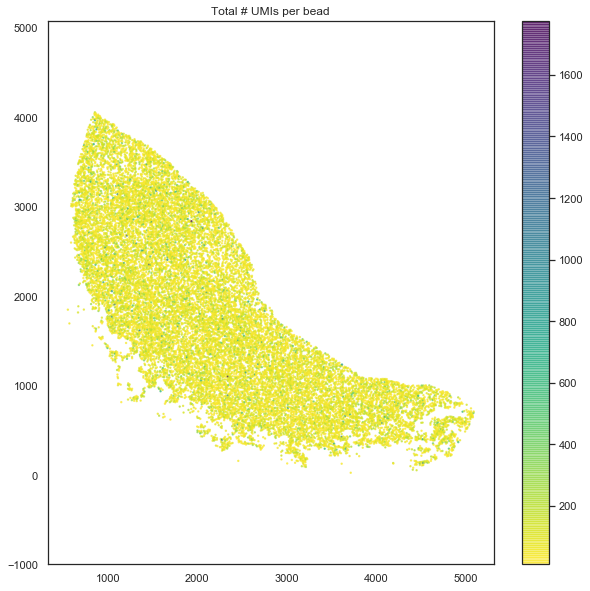

In [19]:
plt.figure(figsize=(10, 10))
plt.set_cmap('viridis_r')
plt.scatter(puck_180819_5.data['slide-seq']['xcoord'], puck_180819_5.data['slide-seq']['ycoord'], 
            c=np.sum(puck_180819_5.data['counts'], axis=1), 
            s=2, alpha=0.6)
plt.colorbar()
plt.axis('equal')
plt.title("Total # UMIs per bead")
plt.show()

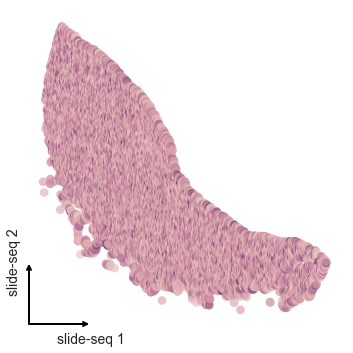

In [12]:
vim_metagene = ['Vim','Ctsd','Gfap','Camk2n1','Hexb','Lcn2','Lgals1','Fabp7','Slc16a11','Ttr','Ctss',
                'Dbi','Mgp','Mrps6','Mt2','Nupr1','Mthfd1','H2-T22','Dhrs1','Pea15a','Pold4','Sdc4','Smc4']
puck_180819_5.plot(data_type='slide-seq', feature_type='counts', features='total')

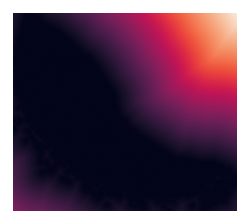

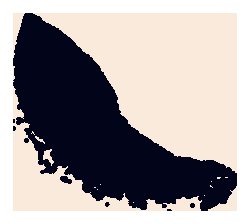

CPU times: user 50.4 s, sys: 350 ms, total: 50.8 s
Wall time: 50.2 s


In [13]:
%%time
# next, we want to map the beads to pixel-space, then trim the pixels by distance threshold using cKDTree from scipy.spatial
puck_180819_5.map_pixels()
puck_180819_5.trim_pixels(threshold=50)

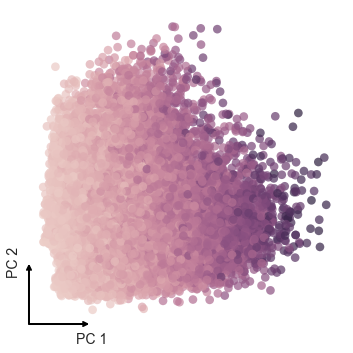

CPU times: user 1min 19s, sys: 7.95 s, total: 1min 27s
Wall time: 40.9 s


In [5]:
%%time 
# now we can perform a PCA on the beads, which represent regions of gene expression patterns in tissue
puck_180819_5.fcc_PCA(data_type='counts', n_components=10, transform='arcsinh')
puck_180819_5.plot(data_type='PCA')

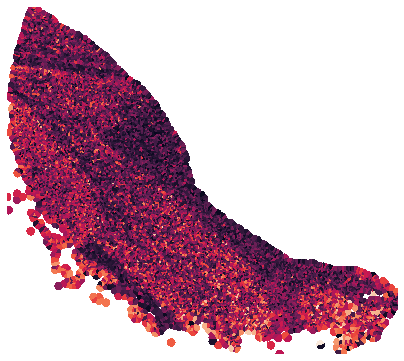

CPU times: user 6.15 s, sys: 84.6 ms, total: 6.23 s
Wall time: 6.24 s


In [30]:
# to reconstruct an image of the tissue, we can overlay the first principal component (data_type='PCA', feature=0) on our pixel-space
%time PC1 = puck_180819_5.assemble_pita(data_type='PCA', features=0, plot_out=True)

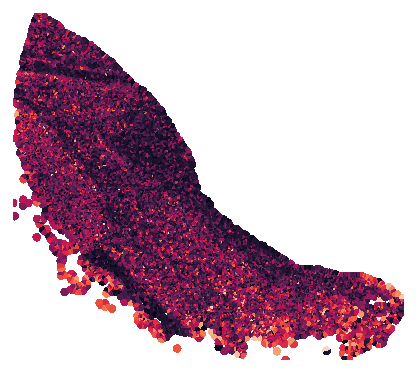

CPU times: user 11.4 s, sys: 2.56 s, total: 13.9 s
Wall time: 13.6 s


In [14]:
# to reconstruct an image of the tissue, we can overlay the first principal component (data_type='PCA', feature=0) on our pixel-space
%time total_counts = puck_180819_5.assemble_pita(feature_type='counts', features='total', transform='arcsinh', plot_out=True)

---
### Build Pita 'Manually'

In [2]:
# read in variable features from Seurat
feat = pd.read_csv('../inputs/puck_180819_5_VarGenes.csv')

In [3]:
%time dge = pd.read_csv('../inputs/puck_180819_5_mappedDGE.csv.gz', index_col=0)

CPU times: user 2min 1s, sys: 11.9 s, total: 2min 13s
Wall time: 2min 16s


In [4]:
dge.shape

(20009, 17027)

In [5]:
# filter for only variable genes
dge_filtered = dge.loc[feat['x'],]

In [6]:
dge_filtered.shape

(2000, 17027)

In [7]:
beads = pd.read_csv('../inputs/puck_180819_5_beads_trim.csv.gz', index_col=0)
beads.sort_values(axis=0, by=['xcoord','ycoord'], inplace=True)

In [8]:
beads.shape

(17027, 2)

In [69]:
%time puck_180819_5 = pita(data=dge_filtered, bead_locs=beads, cells_axis=1, labels=[0,0], data_type='counts')

CPU times: user 20.4 s, sys: 2.58 s, total: 22.9 s
Wall time: 26.4 s


In [70]:
%time puck_180819_5.map_pixels()

CPU times: user 34.9 s, sys: 581 ms, total: 35.5 s
Wall time: 35.9 s


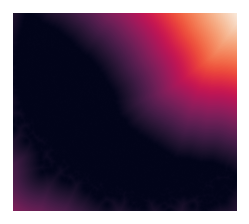

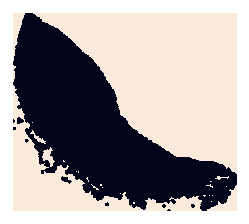

CPU times: user 36.8 s, sys: 1.26 s, total: 38.1 s
Wall time: 39.5 s


In [71]:
%time puck_180819_5.trim_pixels(threshold=40)

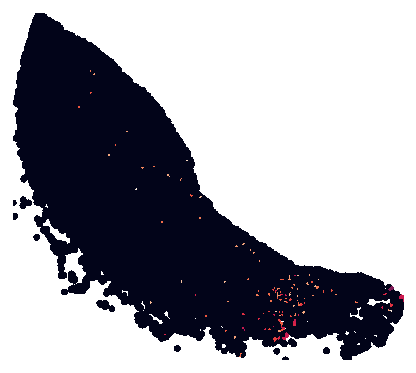

CPU times: user 6.33 s, sys: 1.02 s, total: 7.36 s
Wall time: 9.12 s


In [46]:
# to reconstruct an image of the tissue, we can overlay a single gene on our pixel-space
%time vim = puck_180819_5.assemble_pita(data_type='counts', features='^Vim$', transform='arcsinh')

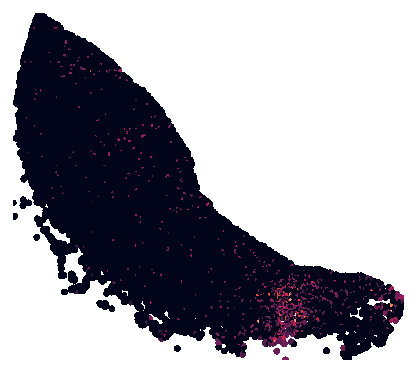

CPU times: user 6.05 s, sys: 1.13 s, total: 7.18 s
Wall time: 7.28 s


In [45]:
# to reconstruct an image of the tissue, we can overlay a metagene on our pixel-space
%time vim_meta = puck_180819_5.assemble_pita(data_type='counts', features=['Vim','Ctsd','Gfap'], transform='arcsinh')

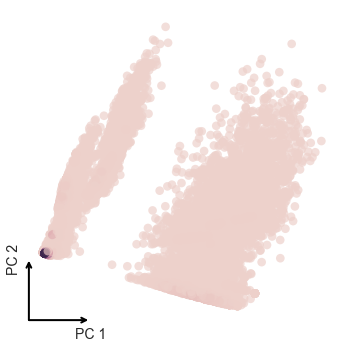

CPU times: user 29.4 s, sys: 5.13 s, total: 34.5 s
Wall time: 38.8 s


In [47]:
%%time 
# now we can perform a PCA on the beads, which represent regions of gene expression patterns in tissue
puck_180819_5.fcc_PCA(data_type='counts', n_components=10, transform='arcsinh')
puck_180819_5.plot(data_type='PCA')

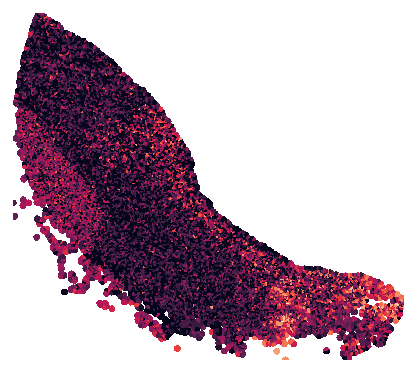

CPU times: user 5.66 s, sys: 829 ms, total: 6.49 s
Wall time: 6.72 s


In [48]:
# to reconstruct an image of the tissue, we can overlay the first two principal components (data_type='PCA', features=[0,1]) on our pixel-space
%time PC1_2 = puck_180819_5.assemble_pita(data_type='PCA', features=[0,1], plot_out=True)

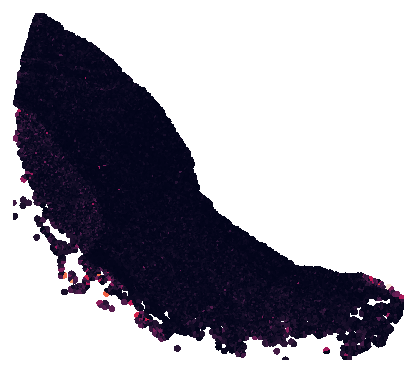

CPU times: user 6.47 s, sys: 1.16 s, total: 7.63 s
Wall time: 8.77 s


In [72]:
# to reconstruct an image of the tissue, we can overlay the first two principal components (data_type='PCA', features=[0,1]) on our pixel-space
%time totUMI = puck_180819_5.assemble_pita(data_type='counts', features='total', transform=None)

---
### __Example 2:__ Read cerebellum dataset to `pita` object

In [73]:
%time cerebellum_slide = pita.from_file(datafile='../inputs/cerebellum_slice_rna.csv.gz', beadfile='../inputs/cerebellum_slice_beads.csv.gz', data_type='counts')

CPU times: user 52.1 s, sys: 4.02 s, total: 56.1 s
Wall time: 57.8 s


Create pixel map for cerebellum dataset to create images from

In [74]:
%time cerebellum_slide.map_pixels()

CPU times: user 3 s, sys: 74.4 ms, total: 3.07 s
Wall time: 3.24 s


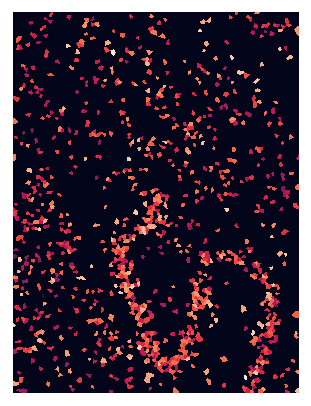

CPU times: user 5.61 s, sys: 2.8 s, total: 8.41 s
Wall time: 11 s


In [75]:
%time aldoc = cerebellum_slide.assemble_pita(data_type='counts', features='Aldoc', transform='arcsinh', trimmed=False)

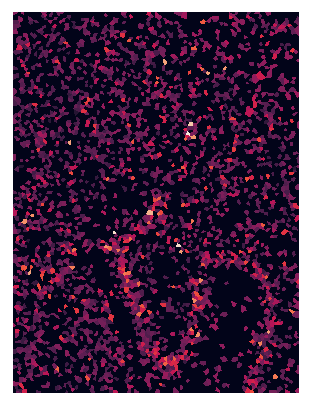

CPU times: user 5.44 s, sys: 2.16 s, total: 7.6 s
Wall time: 8.83 s


In [77]:
%time aldoc_metagene = cerebellum_slide.assemble_pita(data_type='counts', features=['Aldoc','Apoe','Actb','Car7'], transform='arcsinh', trimmed=False)

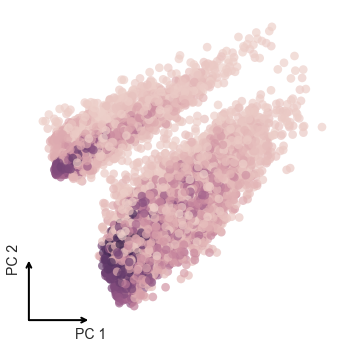

CPU times: user 20.1 s, sys: 3.41 s, total: 23.5 s
Wall time: 20.9 s


In [78]:
%%time 
cerebellum_slide.fcc_PCA(data_type='counts', n_components=10, transform='arcsinh')
cerebellum_slide.plot(data_type='PCA')

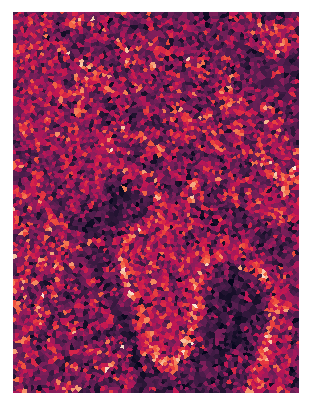

In [80]:
PC1_2 = cerebellum_slide.assemble_pita(data_type='PCA', features=[0,1], plot_out=True, trimmed=False)

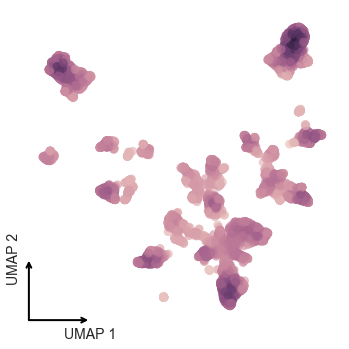

CPU times: user 27.4 s, sys: 1.12 s, total: 28.6 s
Wall time: 29.8 s


In [81]:
%%time 
cerebellum_slide.fcc_UMAP(data_type='PCA', perplexity=30, seed=18)
cerebellum_slide.plot(data_type='UMAP')

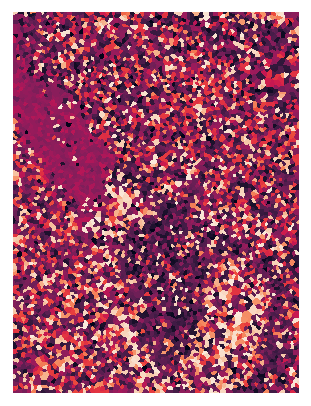

In [86]:
UMAP1_2 = cerebellum_slide.assemble_pita(data_type='UMAP', features='total', plot_out=True, trimmed=False)

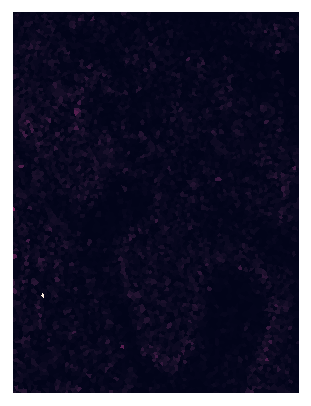

In [85]:
totUMI = cerebellum_slide.assemble_pita(data_type='counts', features='total', plot_out=True, trimmed=False)

In [ ]:
cerebellum_slide.clu['UMAP'].draw_decision_graph()

In [ ]:
cerebellum_slide.clu['UMAP'].assign(100,4)
cerebellum_slide.clu['UMAP'].draw_decision_graph(min_density=cerebellum_slide.clu['UMAP'].min_density, min_delta=cerebellum_slide.clu['UMAP'].min_delta)

In [ ]:
cerebellum_slide.plot_clusters(data_type='UMAP')

In [ ]:
cerebellum_slide.plot(data_type='slide-seq', color=cerebellum_slide.clu['UMAP'].membership)